In [1]:
import io
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import f1_score
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

In [3]:
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
BATCH_SIZE=32
GCS_DS_PATH = KaggleDatasets().get_gcs_path("kfoldtfrecordspinsdataset")

In [5]:
def Parse_TfRecords(record):
    features={"image":tf.io.FixedLenFeature([],tf.string),
         "label":tf.io.FixedLenFeature([],tf.int64)}
    example=tf.io.parse_single_example(record,features=features)
    image=tf.io.decode_raw(example['image'],tf.uint8)
    image=tf.cast(image,tf.float32)
    image=tf.reshape(image,shape=[256,256,3])
    image=image/255.0
    image=tf.clip_by_value(image, 0.0, 1.0)
    label=example['label']
    return image,label

In [6]:
kfolds=tf.io.gfile.glob(f"{GCS_DS_PATH}/TFRecords/TFRecords/pin_faces_fold_*.tfrec")
kfolds

['gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_0.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_1.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_2.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_3.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_4.tfrec']

In [7]:
def TFRecords_Dataset(folds,BATCH_SIZE):
    data=tf.data.TFRecordDataset(folds)
    data=data.map(Parse_TfRecords,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data=data.batch(BATCH_SIZE)
    data=data.prefetch(tf.data.experimental.AUTOTUNE)
    return data 

In [8]:
from tensorflow.keras.applications import DenseNet201
import math

In [9]:
class ArcFace(tf.keras.layers.Layer):
    def __init__(self,m,s,n_classes):
        super().__init__()
        self.m=m
        self.s=s
        self.classes=n_classes
        self.cos_m=tf.math.cos(m)
        self.sin_m=tf.math.sin(m)
        self.threshold=tf.math.cos(math.pi-m)
        self.mm=tf.math.sin(math.pi-m)*m
    
    def build(self,input_shape):
        prev=input_shape[0][-1]
        self.w=self.add_weight(shape=(prev,self.classes),initializer='glorot_uniform',trainable=True,dtype=tf.float32)
    
    def call(self,inputs):
        x,y=inputs
        norm_x=tf.linalg.l2_normalize(x,axis=-1)
        norm_w=tf.linalg.l2_normalize(self.w,axis=0)
        cosine=tf.linalg.matmul(norm_x,norm_w)
        sin_theta=tf.sqrt(1.0-tf.square(cosine))
        y_one_hot=tf.cast(tf.one_hot(y,self.classes),dtype=tf.float32)
        cos_theta_m=(self.cos_m*cosine)-(self.sin_m*sin_theta)    
        cos_theta_m=tf.where(cosine>self.threshold,cos_theta_m,cosine-self.mm)
        final=(y_one_hot*cos_theta_m)+((1-y_one_hot)*cosine)
        final=self.s*final
        return final

In [10]:
def GetModel(m,path):
    s=30.0
    neurons=1024
    N_CLASSES=100
    tf.keras.backend.clear_session()
    arc_layer=ArcFace(m,s,N_CLASSES)
    pre_trained=DenseNet201(include_top=False,input_shape=(256,256,3))
    pre_trained.trainable=True
    Y=tf.keras.layers.Input(shape=(),dtype=tf.int32)
    x=tf.keras.layers.GlobalAveragePooling2D()(pre_trained.output)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(units=neurons)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.ReLU()(x)
    x=arc_layer((x,Y))
    output_layer=tf.keras.layers.Softmax()(x)
    model=tf.keras.models.Model(inputs=(pre_trained.input,Y),outputs=output_layer)
    model.load_weights(path)
    model.trainable=False
    emb_model=tf.keras.models.Model(inputs=model.input[0],outputs=model.layers[-4].output)
    emb_model.trainable=False
    return emb_model

# From 5 persons we will use 3 persons to check how model is working for new faces

In [11]:
def Get_Embeddings_Labels(tf_data,emb_model,batch_size,data_size):
    train_embeddings=np.empty((data_size,1024))
    train_labels=np.empty((data_size,),dtype=np.int32)
    for batch,(images,labels) in enumerate(tf_data):
        temp_embeddings=emb_model.predict(images,verbose=0)
        start=batch*batch_size
        end=(batch+1)*batch_size
        if end>data_size:
            end=data_size
        train_embeddings[start:end]=temp_embeddings
        train_labels[start:end]=labels
    return train_embeddings,train_labels

In [12]:
def Get_Similarity_indexs(query,keys,threshold,top_k):
    query=tf.linalg.l2_normalize(query,axis=-1)
    cosines=tf.linalg.matmul(query,keys,transpose_b=True)
    indices=tf.where(cosines>threshold)
    good_cosines=tf.gather_nd(cosines,indices)
    indices=indices[:,-1].numpy()
    top_good_cosine_idx=tf.argsort(good_cosines,direction='DESCENDING')[:top_k]
    top_indx=indices[top_good_cosine_idx.numpy()]
    return top_indx

In [13]:
def Log_Plot(heatmap,group,job_type):
    run=wandb.init(project="FaceRecognition-kfold",group=group,job_type=f"top_k={job_type}")
    run.log({"heatmap": wandb.Image(heatmap.get_figure())})
    wandb.finish()

# We will check first without having embeddings of these 3 persons in our database. When we send the images what it is predicting. In ideal case we should get 0

In [14]:
df=pd.read_csv(f"{GCS_DS_PATH}/TFRecords/TFRecords/Train_face.csv")

In [15]:
train_size=df.shape[0]

In [16]:
test=pd.read_csv(f"{GCS_DS_PATH}/TFRecords/TFRecords/Final_Test.csv")

In [17]:
set(df['name']).intersection(set(test['name']))

set()

In [18]:
random_persons=np.random.choice(test['name'].unique(),size=3,replace=False)
random_persons

array(['Andy Samberg', 'Shakira Isabel Mebarak', 'melissa fumero'],
      dtype=object)

In [19]:
test=test.loc[test['name'].isin(random_persons)].reset_index(drop=True)
test_size=test.shape[0]

In [20]:
kfolds

['gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_0.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_1.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_2.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_3.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/TFRecords/TFRecords/pin_faces_fold_4.tfrec']

In [21]:
test_folds=[]
for person in random_persons:
    path=f"{GCS_DS_PATH}/Evaluate Persons/Evaluate Persons/pin_{person}_records.tfrec"
    test_folds.append(path)
test_folds

['gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/Evaluate Persons/Evaluate Persons/pin_Andy Samberg_records.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/Evaluate Persons/Evaluate Persons/pin_Shakira Isabel Mebarak_records.tfrec',
 'gs://kds-ade40411c0be59170812b1f7f838c407b46f9a978b1c26c45f9ceaf7/Evaluate Persons/Evaluate Persons/pin_melissa fumero_records.tfrec']

In [22]:
False_Positives_dict={}
for m in [0.0,0.2,0.4,0.5,0.8]:
    False_Positives_dict[m]={}
    for threshold in [0.6,0.7,0.8]:
        False_Positives_dict[m][threshold]=[]
False_Positives_dict

{0.0: {0.6: [], 0.7: [], 0.8: []},
 0.2: {0.6: [], 0.7: [], 0.8: []},
 0.4: {0.6: [], 0.7: [], 0.8: []},
 0.5: {0.6: [], 0.7: [], 0.8: []},
 0.8: {0.6: [], 0.7: [], 0.8: []}}

In [23]:
top_k=20

In [24]:
for m in [0.0,0.2,0.4,0.5,0.8]:
    print(f"running for m {m}")
    for fold in range(5):
        path=f"/kaggle/input/pins-face-m-variation-models/M-Variation-models/m={m}/fold-{fold}.h5"
        emb_model=GetModel(m,path)
        train_data=TFRecords_Dataset(kfolds,BATCH_SIZE)
        Train_Embeddings,Train_Labels=Get_Embeddings_Labels(train_data,emb_model,BATCH_SIZE,train_size)
        Train_Embeddings=tf.linalg.l2_normalize(Train_Embeddings,axis=-1)
        #########################
        test_data=TFRecords_Dataset(test_folds,BATCH_SIZE)
        Test_Embeddings,Test_Labels=Get_Embeddings_Labels(test_data,emb_model,BATCH_SIZE,test_size)
        #############3 person embeddings##########
        print("got the embeddings")
        for threshold in [0.6,0.7,0.8]:
            false_pos=0
            for i in tqdm(range(test_size)):
                temp_embed=np.expand_dims(Test_Embeddings[i,...],axis=0)
                true_label=Test_Labels[i]
                idx=Get_Similarity_indexs(temp_embed,Train_Embeddings,threshold,top_k)
                false_pos+=idx.shape[0]
            mean_false=false_pos/test_size
            False_Positives_dict[m][threshold].append(mean_false)

running for m 0.0
74836368/74836368 [==============================] - 3s 0us/step
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 414.62it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 408.29it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 406.91it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 406.80it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 414.98it/s]


running for m 0.2
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 406.68it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 401.82it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 396.29it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 397.41it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 407.20it/s]


running for m 0.4
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 380.95it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 407.46it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 375.20it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 406.36it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 391.44it/s]


running for m 0.5
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 401.81it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 388.24it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 397.48it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 393.93it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 355.35it/s]


running for m 0.8
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 391.04it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 389.10it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 393.66it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 395.91it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 394.21it/s]


In [25]:
results=pd.DataFrame(False_Positives_dict)
results=results.unstack().reset_index()
results.columns=["m","threshold","false_pos"]
results=results.explode("false_pos")

wandb: Currently logged in as: raviteja_. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230710_202229-pgw1pk53
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run feasible-sea-84
wandb: ⭐️ View project at https://wandb.ai/raviteja_/FaceRecognition-kfold
wandb: 🚀 View run at https://wandb.ai/raviteja_/FaceRecognition-kfold/runs/pgw1pk53
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run feasible-sea-84 at: https://wandb.ai/raviteja_/FaceRecognition-kfold/runs/pgw1pk53
wandb: Synced 5 W&B file(s), 1 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230710_202229-pgw1pk53/logs


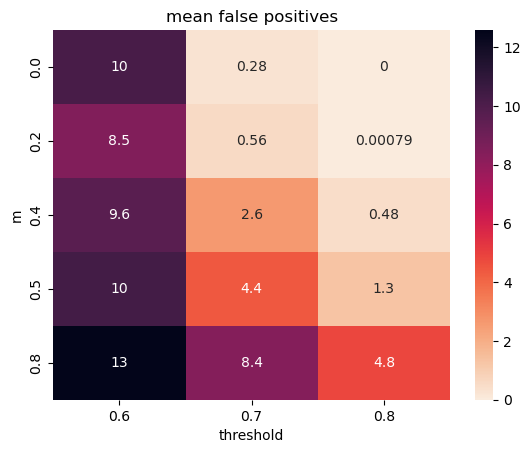

In [26]:
heatmap=sn.heatmap(pd.pivot_table(data=results,index="m",columns='threshold',values='false_pos'),annot=True,
           cmap="rocket_r")
heatmap.set_title("mean false positives")
Log_Plot(heatmap,"false_positives",top_k)

In [27]:
mean_precision_score_dict={}
mean_recall_score_dict={}
mean_f1_score_dict={}
for m in [0.0,0.2,0.4,0.5,0.8]:
    mean_precision_score_dict[m]={}
    mean_recall_score_dict[m]={}
    mean_f1_score_dict[m]={}
    for threshold in [0.6,0.7,0.8]:
        mean_precision_score_dict[m][threshold]=[]
        mean_recall_score_dict[m][threshold]=[]
        mean_f1_score_dict[m][threshold]=[]
print(mean_precision_score_dict)
print(mean_recall_score_dict)
print(mean_f1_score_dict)

{0.0: {0.6: [], 0.7: [], 0.8: []}, 0.2: {0.6: [], 0.7: [], 0.8: []}, 0.4: {0.6: [], 0.7: [], 0.8: []}, 0.5: {0.6: [], 0.7: [], 0.8: []}, 0.8: {0.6: [], 0.7: [], 0.8: []}}
{0.0: {0.6: [], 0.7: [], 0.8: []}, 0.2: {0.6: [], 0.7: [], 0.8: []}, 0.4: {0.6: [], 0.7: [], 0.8: []}, 0.5: {0.6: [], 0.7: [], 0.8: []}, 0.8: {0.6: [], 0.7: [], 0.8: []}}
{0.0: {0.6: [], 0.7: [], 0.8: []}, 0.2: {0.6: [], 0.7: [], 0.8: []}, 0.4: {0.6: [], 0.7: [], 0.8: []}, 0.5: {0.6: [], 0.7: [], 0.8: []}, 0.8: {0.6: [], 0.7: [], 0.8: []}}


In [28]:
top_k=20
for m in [0.0,0.2,0.4,0.5,0.8]:
    print(f"running for m {m}")
    for fold in range(5):
        path=f"/kaggle/input/pins-face-m-variation-models/M-Variation-models/m={m}/fold-{fold}.h5"
        emb_model=GetModel(m,path)
        train_data=TFRecords_Dataset(kfolds,BATCH_SIZE)
        Train_Embeddings,Train_Labels=Get_Embeddings_Labels(train_data,emb_model,BATCH_SIZE,train_size)
        Train_Embeddings=tf.linalg.l2_normalize(Train_Embeddings,axis=-1)
        #########################
        test_data=TFRecords_Dataset(test_folds,BATCH_SIZE)
        Test_Embeddings,Test_Labels=Get_Embeddings_Labels(test_data,emb_model,BATCH_SIZE,test_size)
        #############3 person embeddings##########
        temp_train=tf.linalg.l2_normalize(Test_Embeddings,axis=-1)
        Train_Embeddings=tf.concat([Train_Embeddings, temp_train], 0)
        Train_Labels=tf.concat([Train_Labels,Test_Labels], 0).numpy()
        #########Combined#########################
        print("got the embeddings")
        for threshold in [0.6,0.7,0.8]:
            mean_precision_score=0
            mean_recall_score=0
            mean_f1_score=0
            for i in tqdm(range(test_size)):
                temp_embed=np.expand_dims(Test_Embeddings[i,...],axis=0)
                true_label=Test_Labels[i]
                idx=Get_Similarity_indexs(temp_embed,Train_Embeddings,threshold,top_k)
                predicted=np.where(Train_Labels[idx]==true_label,1,0).tolist()
                p=(sum(predicted)/(len(predicted)+1e-5))
                r=(sum(predicted)/(top_k))
                mean_precision_score+=p
                mean_recall_score+=r
                mean_f1_score+=((2*p*r)/(p+r+1e-5))
            mean_precision_score=mean_precision_score/test_size
            mean_recall_score=mean_recall_score/test_size
            mean_f1_score=mean_f1_score/test_size
            mean_precision_score_dict[m][threshold].append(mean_precision_score)   
            mean_recall_score_dict[m][threshold].append(mean_recall_score)   
            mean_f1_score_dict[m][threshold].append(mean_f1_score)

running for m 0.0
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 345.01it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 339.10it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 346.33it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 304.69it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 343.97it/s]


running for m 0.2
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 346.75it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 328.86it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 331.13it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 337.34it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 346.39it/s]


running for m 0.4
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 343.90it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 350.75it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 336.29it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 331.90it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 346.22it/s]


running for m 0.5
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 347.16it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 344.05it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 353.40it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 325.05it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 341.09it/s]


running for m 0.8
got the embeddings


100%|██████████| 504/504 [00:01<00:00, 330.55it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 348.77it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 347.73it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 332.21it/s]


got the embeddings


100%|██████████| 504/504 [00:01<00:00, 345.65it/s]


Text(0.5, 1.0, 'mean precision score for 5 folds')

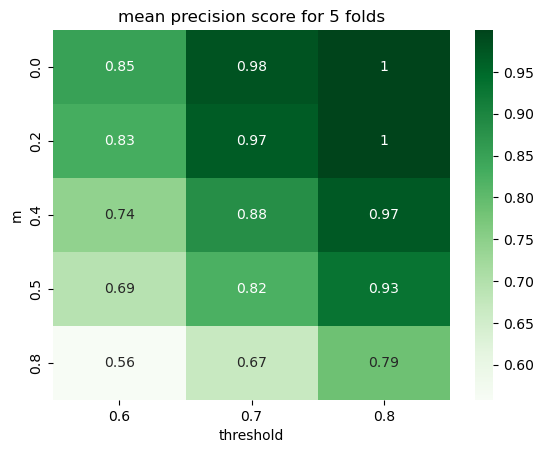

In [29]:
results=pd.DataFrame(mean_precision_score_dict)
results=results.unstack().reset_index()
results.columns=["m","threshold","mean_precision"]
results=results.explode("mean_precision")
plot=sn.heatmap(pd.pivot_table(data=results,index="m",columns='threshold',values='mean_precision')
                ,annot=True,
           cmap="Greens")
plot.set_title("mean precision score for 5 folds")

Text(0.5, 1.0, 'mean recall score for 5 folds')

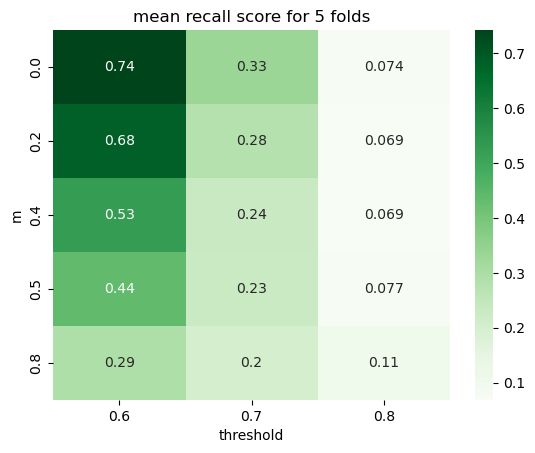

In [30]:
results=pd.DataFrame(mean_recall_score_dict)
results=results.unstack().reset_index()
results.columns=["m","threshold","mean_recall"]
results=results.explode("mean_recall")
plot=sn.heatmap(pd.pivot_table(data=results,index="m",columns='threshold',values='mean_recall')
                ,annot=True,
           cmap="Greens")
plot.set_title("mean recall score for 5 folds")

wandb: wandb version 0.15.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230710_215524-qp372575
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run peach-bush-86
wandb: ⭐️ View project at https://wandb.ai/raviteja_/FaceRecognition-kfold
wandb: 🚀 View run at https://wandb.ai/raviteja_/FaceRecognition-kfold/runs/qp372575
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run peach-bush-86 at: https://wandb.ai/raviteja_/FaceRecognition-kfold/runs/qp372575
wandb: Synced 5 W&B file(s), 1 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230710_215524-qp372575/logs


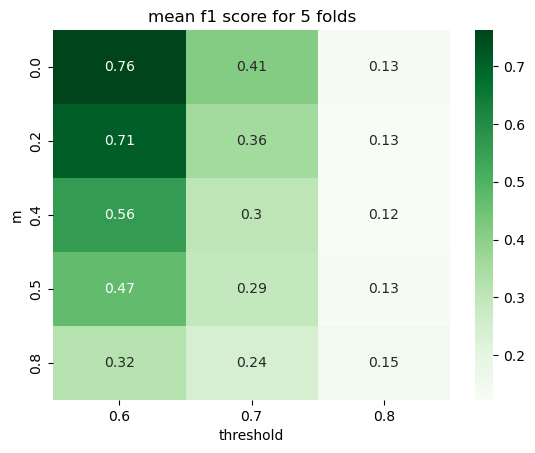

In [31]:
results=pd.DataFrame(mean_f1_score_dict)
results=results.unstack().reset_index()
results.columns=["m","threshold","mean_f1"]
results=results.explode("mean_f1")
heatmap=sn.heatmap(pd.pivot_table(data=results,index="m",columns='threshold',values='mean_f1'),
                   annot=True,cmap="Greens")
heatmap.set_title("mean f1 score for 5 folds")
Log_Plot(heatmap,"mean_f1_score",top_k)